In [1]:
import numpy as np
import pandas as pd
from collections import Counter
from scrabble_assistant import read_json
from scrabble_assistant import calculate_word_value
from scrabble_assistant import is_word_correct
from scrabble_assistant import is_word_available
from scrabble_assistant import get_regex_patterns
from scrabble_assistant import get_marked_rows

# Считываем словарь

In [2]:
rus_words_data = pd.read_csv('dictionary.txt', 
                             header=None,
                             names=['word'])
rus_words_data

,word
0,аарон
1,абажур
2,абакан
3,абалкин
4,абатуров
...,...
17042,ящер
17043,ящерица
17044,ящерка
17045,ящик


# Добавляем колонку с длиной слова

In [3]:
rus_words_data['length'] = rus_words_data.word.apply(lambda x: len(x))
rus_words_data

,word,length
0,аарон,5
1,абажур,6
2,абакан,6
3,абалкин,7
4,абатуров,8
...,...,...
17042,ящер,4
17043,ящерица,7
17044,ящерка,6
17045,ящик,4


# Убираем слова длинее 15 букв

In [4]:
rus_words_data = rus_words_data.query('length <= 15')
rus_words_data

,word,length
0,аарон,5
1,абажур,6
2,абакан,6
3,абалкин,7
4,абатуров,8
...,...,...
17042,ящер,4
17043,ящерица,7
17044,ящерка,6
17045,ящик,4


# Убираем слова с неожиданными символами и содержащие больше букв, чем есть в игре

In [5]:
rus_words_data['is_correct'] = rus_words_data.word.apply(lambda x: is_word_correct(x, 'letters_values.json'))
rus_words_data = rus_words_data.query('is_correct == True')
rus_words_data.drop('is_correct', axis=1) # больше не нужна

,word,length
0,аарон,5
1,абажур,6
2,абакан,6
3,абалкин,7
4,абатуров,8
...,...,...
17042,ящер,4
17043,ящерица,7
17044,ящерка,6
17045,ящик,4


# Вы не видели никаких предупреждений. Блокнот идеален.
<img alt="Медики научились стирать память | Новые Известия" class="n3VNCb" src="https://newizv.ru/attachments/317af9c89fc354109c47c029ed16c501e5db3bb5/store/fill/1200/675/b8d575d01c39e48984e1c38e7749fb2cb856c4c95c1aec1038be76212e09/b8d575d01c39e48984e1c38e7749fb2cb856c4c95c1aec1038be76212e09.jpg" data-noaft="1" jsname="HiaYvf" jsaction="load:XAeZkd;" style="width: 434px; height: 244.125px; margin: 0px;">

In [6]:
rus_words_data['value'] = rus_words_data.word.apply(lambda x: calculate_word_value(x, 'letters_values.json'))
rus_words_data

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,word,length,is_correct,value
0,аарон,5,True,6
1,абажур,6,True,15
2,абакан,6,True,9
3,абалкин,7,True,11
4,абатуров,8,True,15
...,...,...,...,...
17042,ящер,4,True,16
17043,ящерица,7,True,28
17044,ящерка,6,True,19
17045,ящик,4,True,16


# Отранжируем слова по цене (без учета бонусных полей на доске).

In [7]:
rus_words_data.sort_values(by='value', ascending=False)

,word,length,is_correct,value
2547,вышивальщица,12,True,50
6069,компьютеризация,15,True,48
16499,шифровальщик,12,True,47
4126,ефросиньюшка,12,True,46
16823,эмоциональность,15,True,45
...,...,...,...,...
536,ар,2,True,3
7891,ми,2,True,3
4093,ена,3,True,3
12386,ре,2,True,3


# Найдем все слова, которые можем составить с заданным набором букв.

In [8]:
rus_words_data['available'] = rus_words_data.word.apply(lambda x: is_word_available(Counter('абвгдеё'), x))
rus_words_data.query('available == True')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,word,length,is_correct,value,available
120,ад,2,True,3,True
935,бд,2,True,5,True
938,бег,3,True,7,True
939,бега,4,True,8,True
947,беда,4,True,7,True
1779,вега,4,True,7,True
2572,га,2,True,4,True
2581,гад,3,True,6,True
2702,гб,2,True,6,True
3384,дева,4,True,6,True


# Из букв 'абвгдеё' можно составить вышеперчисленные слова.

# Тест функций get_marked_rows и get_regex_patterns:

In [9]:
test_board = [
        ['', '', '', '', '', '', '', '', '', '', '', '', '', '', ''],
        ['', '', '', '', '', '', '', '', '', '', '', '', '', '', ''],
        ['', '', '', '', '', '', '', '', '', 'т', '', '', '', '', ''],
        ['', '', '', '', '', '', '', '', '', 'о', '', '', '', '', ''],
        ['', '', '', 'п', 'о', 'c', 'е', 'л', 'о', 'к', '', '', '', '', ''],
        ['', '', '', 'а', '', 'а', '', '', '', '', '', 'р', '', '', ''],
        ['', '', '', 'п', '', 'д', 'о', 'м', '', 'я', '', 'е', '', '', ''],
        ['', '', '', 'а', '', '', '', 'а', 'з', 'б', 'у', 'к', 'а', '', ''],
        ['', '', '', '', '', 'с', 'о', 'м', '', 'л', '', 'а', '', '', ''],
        ['', '', '', 'я', 'м', 'а', '', 'а', '', 'о', '', '', '', '', ''],
        ['', '', '', '', '', 'л', '', '', '', 'к', 'и', 'т', '', '', ''],
        ['', '', '', '', 'с', 'о', 'л', 'ь', '', 'о', '', '', '', '', ''],
        ['', '', '', '', '', '', '', '', '', '', '', '', '', '', ''],
        ['', '', '', '', '', '', '', '', '', '', '', '', '', '', ''],
        ['', '', '', '', '', '', '', '', '', '', '', '', '', '', ''],
    ]

In [10]:
test_row_after_sharping = get_marked_rows(test_board)[5]
test_row_after_sharping

['', '', '', 'а', '#', 'а', '#', '#', '#', '#', '', 'р', '', '', '']

In [ ]:
def is_word_fits_in_pattern(sharped_row: [str], word: str) -> bool:
    result = []
    patterns = get_regex_patterns(sharped_row)
    
    for pattern in patterns:
        if pattern.findall(word):
            if pattern.findall(word).pop() == word:
                result.append(pattern.findall(word))
    return result

In [ ]:
is_word_fits_in_pattern(test_row_after_sharping, 'аркан')

In [ ]:
is_word_fits_in_pattern(test_row_after_sharping, 'арка')

In [ ]:
patterns = get_regex_patterns(test_row_after_sharping)
patterns

In [ ]:
result = []
for pat in patterns:
    result.append(pat.findall('арка'))
result
print(result[0][0])

# Работают корректно. Прогоним эти функции на нашем словаре, для тестовой строки. Найдем слова, которые подходят в нее:

In [ ]:
rus_words_data['word_fits'] = rus_words_data.word.apply(lambda x: is_word_fits_in_pattern(test_row_after_sharping, x))
rus_words_data

In [ ]:
rus_words_data.query("word == 'арка'")

# Писалось в 5 утра. Потом приведу в адекватный вид.

In [ ]:
rus_words_data['is_word_found'] = rus_words_data.word_fits.apply(lambda x: len(x))
rus_words_data

In [ ]:
founded_words_data = rus_words_data.query("is_word_found > 0")
founded_words_data

# В тестовый ряд подходит 776 слова из словаря.

# Найдем самое ценное:

In [ ]:
founded_words_data.sort_values(by='value', ascending=False)

# Слово 'шрифт' действительно подходит!

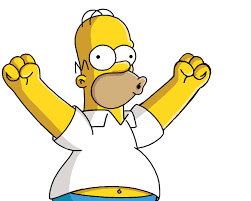

In [12]:
is_word_fits_in_pattern(test_row_after_sharping, 'аркан')

[['аркан']]

In [13]:
is_word_fits_in_pattern(test_row_after_sharping, 'арка')

[['арка'], ['арка']]

In [14]:
patterns = get_regex_patterns(test_row_after_sharping)
patterns

[re.compile(r'[а-я]{,1}[а-я]{,1}[а-я]{,1}а$', re.UNICODE),
 re.compile(r'[а-я]{,1}р[а-я]{,1}[а-я]{,1}[а-я]{,1}', re.UNICODE)]

In [15]:
result = []
for pat in patterns:
    result.append(pat.findall('арка'))
result
print(result[0][0])

арка


# Работают корректно. Прогоним эти функции на нашем словаре, для тестовой строки. Найдем слова, которые подходят в нее:

In [16]:
rus_words_data['word_fits'] = rus_words_data.word.apply(lambda x: is_word_fits_in_pattern(test_row_after_sharping, x))
rus_words_data

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,word,length,is_correct,value,available,word_fits
0,аарон,5,True,6,False,[]
1,абажур,6,True,15,False,[]
2,абакан,6,True,9,False,[]
3,абалкин,7,True,11,False,[]
4,абатуров,8,True,15,False,[]
...,...,...,...,...,...,...
17042,ящер,4,True,16,False,[]
17043,ящерица,7,True,28,False,[]
17044,ящерка,6,True,19,False,[]
17045,ящик,4,True,16,False,[]


In [17]:
rus_words_data.query("word == 'арка'")

,word,length,is_correct,value,available,word_fits
571,арка,4,True,6,False,"[[арка], [арка]]"


# Писалось в 5 утра. Потом приведу в адекватный вид.

In [18]:
rus_words_data['is_word_found'] = rus_words_data.word_fits.apply(lambda x: len(x))
rus_words_data

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,word,length,is_correct,value,available,word_fits,is_word_found
0,аарон,5,True,6,False,[],0
1,абажур,6,True,15,False,[],0
2,абакан,6,True,9,False,[],0
3,абалкин,7,True,11,False,[],0
4,абатуров,8,True,15,False,[],0
...,...,...,...,...,...,...,...
17042,ящер,4,True,16,False,[],0
17043,ящерица,7,True,28,False,[],0
17044,ящерка,6,True,19,False,[],0
17045,ящик,4,True,16,False,[],0


In [19]:
founded_words_data = rus_words_data.query("is_word_found > 0")
founded_words_data

,word,length,is_correct,value,available,word_fits,is_word_found
121,ада,3,True,4,False,[[ада]],1
154,аида,4,True,5,False,[[аида]],1
158,ака,3,True,4,False,[[ака]],1
216,ала,3,True,4,False,[[ала]],1
270,алла,4,True,6,False,[[алла]],1
...,...,...,...,...,...,...,...
17027,ярус,4,True,10,False,[[ярус]],1
17036,яуза,4,True,12,False,[[яуза]],1
17037,яхта,4,True,11,False,[[яхта]],1
17040,яша,3,True,14,False,[[яша]],1


# В тестовый ряд подходит 776 слова из словаря.

# Найдем самое ценное:

In [20]:
founded_words_data.sort_values(by='value', ascending=False)

,word,length,is_correct,value,available,word_fits,is_word_found
16577,шрифт,5,True,25,False,[[шрифт]],1
653,арюша,5,True,24,False,[[арюша]],1
16955,юраша,5,True,24,False,[[юраша]],1
15149,тюша,4,True,23,False,[[тюша]],1
14435,сюша,4,True,23,False,[[сюша]],1
...,...,...,...,...,...,...,...
346,ана,3,True,3,False,[[ана]],1
9873,па,2,True,3,False,[[па]],1
5122,ир,2,True,3,False,[[ир]],1
536,ар,2,True,3,False,[[ар]],1


# Слово 'шрифт' действительно подходит!

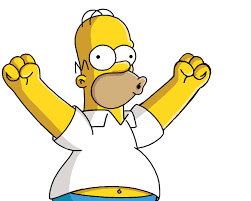